<a href="https://colab.research.google.com/github/Shinjiray/Xakaton_detal/blob/main/cnnresnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### (The accuracy of this model came out to be 94.2%)

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparataion and visualisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

# Путь к директории, которую вы хотите очистить (в данном случае, /content)
directory_to_clear = '/content'

# Директории, которые вы хотите оставить
directories_to_keep = ['/content/.config', '/content/.ipynb_checkpoints', '/content/sample_data', '/content/drive']

# Проходимся по всем файлам и директориям внутри /content
for filename in os.listdir(directory_to_clear):
    file_path = os.path.join(directory_to_clear, filename)
    try:
        if file_path not in directories_to_keep:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
    except Exception as e:
        print(f"Не удалось удалить {file_path}: {e}")

print("Файлы и директории в /content были очищены, кроме указанных.")


Файлы и директории в /content были очищены, кроме указанных.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

#папкаобщ
dataset_dir = '/content/drive/MyDrive/Детали'
Dataclass = dataset_dir
#папкатрейн
train_dir = '/content/train_dir'
os.makedirs(train_dir, exist_ok=True)

#папка тест
test_dir = '/content/test_dir'
os.makedirs(test_dir, exist_ok=True)

#папкавал
val_dir = '/content/val_dir'
os.makedirs(val_dir, exist_ok=True)

Если захотим больше данных, то можно попробовать их создать вручную. Создаем новый new_dir и в дальнейшем , вместо dataset_dir, работаем только с ним

In [ ]:
import os
from PIL import Image, ImageEnhance, ImageOps, ImageChops
import random
import shutil

# Путь к исходной папке с изображениями
dataset_dir = '/content/drive/MyDrive/Детали'

# Путь к новой папке, которую вы хотите создать
new_dir = '/content/new_dataset'

# Создаем новую папку
os.makedirs(new_dir, exist_ok=True)

# Функция для редактирования изображения
def edit_image(image):
    # Отзеркаливание (случайно)
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Прибавление фотографии до +20% (случайно)
    enhancer = ImageEnhance.Brightness(image)
    factor = 1 + (random.random() * 0.2)
    image = enhancer.enhance(factor)

    # Вращение изображения (случайно)
    if random.random() > 0.5:
        angle = random.randint(-20, 20)
        image = image.rotate(angle)

    # Изменение цветокоррекции (случайно)
    enhancer = ImageEnhance.Color(image)
    factor = random.uniform(0.8, 1.2)
    image = enhancer.enhance(factor)

    return image

# Копируем изображения и применяем редактирование
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    new_class_path = os.path.join(new_dir, class_folder)
    os.makedirs(new_class_path, exist_ok=True)

    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = Image.open(img_path)

        # Редактируем изображение
        edited_img = edit_image(img)

        # Сохраняем редактированное изображение в новую папку
        edited_img.save(os.path.join(new_class_path, filename))

        # Копируем исходное изображение в новую папку без редактирования
        shutil.copy(img_path, os.path.join(new_class_path, "original_" + filename))

# Готово
print("Редактирование изображений и копирование исходных завершено.")


KeyboardInterrupt: ignored

In [ ]:
# Получите список папок с названиями классов
class_names = os.listdir(dataset_dir)

# Переберите каждую папку класса и разделите данные на тренировочный, тестовый и валидационный наборы
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    # список файлов в текущей папке класса
    file_list = os.listdir(class_dir)

    # Разделение данных
    train_files, test_val_files = train_test_split(file_list, test_size=0.3, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)
    #Распределение по папкам
    for file in train_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(train_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(test_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


In [ ]:
img_height,img_width=224,224
batch_size=32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 451 files belonging to 19 classes.
Found 107 files belonging to 19 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['CS120.01.413', 'CS120.07.442', 'CS150.01.427-01', 'SU160.00.404', 'SU80.01.426', 'SU80.10.409A', 'ЗВТ86.103К-02', 'СВМ.37.060', 'СВМ.37.060А', 'СВП-120.00.060', 'СВП120.42.020', 'СВП120.42.030', 'СК20.01.01.01.406', 'СК20.01.01.02.402', 'СК30.01.01.02.402', 'СК30.01.01.03.403', 'СК50.01.01.404', 'СК50.02.01.411', 'СПО250.14.190']


In [ ]:
len(class_names)

19

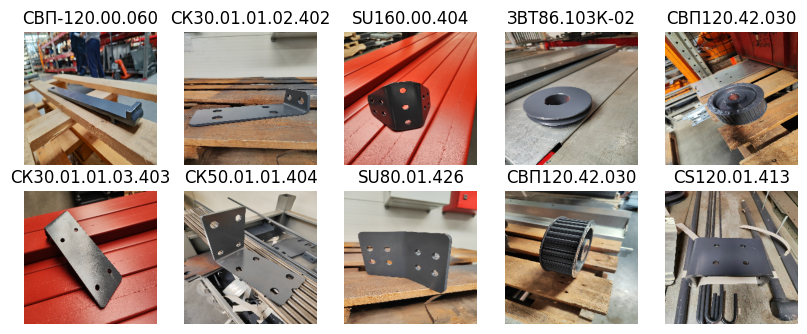

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Using Resnet50 as base model:

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
model = Sequential()

base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=19,
                   weights='imagenet')


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Freezing the pre-trained layers so that we do not have to update weights ourselves:

In [ ]:
for layer in base_model.layers:
        layer.trainable=False

## Building model:

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(100, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               51300     
                                                                 
Total params: 24688100 (94.18 MB)
Trainable params: 1100388 (4.20 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Training our model:

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,

                   )


Epoch 1/10
15/15 [==============================] - 58s 2s/step - loss: 3.1900 - accuracy: 0.2306 - val_loss: 1.3038 - val_accuracy: 0.5888
Epoch 2/10
15/15 [==============================] - 44s 2s/step - loss: 1.2929 - accuracy: 0.5987 - val_loss: 1.0205 - val_accuracy: 0.6542
Epoch 3/10
15/15 [==============================] - 44s 2s/step - loss: 0.9359 - accuracy: 0.7095 - val_loss: 0.9123 - val_accuracy: 0.6916
Epoch 4/10
15/15 [==============================] - 42s 1s/step - loss: 0.7334 - accuracy: 0.7605 - val_loss: 0.7283 - val_accuracy: 0.7664
Epoch 5/10
15/15 [==============================] - 43s 1s/step - loss: 0.4834 - accuracy: 0.8426 - val_loss: 0.6208 - val_accuracy: 0.8131
Epoch 6/10
15/15 [==============================] - 43s 1s/step - loss: 0.4404 - accuracy: 0.8625 - val_loss: 0.7344 - val_accuracy: 0.7477
Epoch 7/10
15/15 [==============================] - 42s 1s/step - loss: 0.3756 - accuracy: 0.8869 - val_loss: 0.6324 - val_accuracy: 0.7850
Epoch 8/10
15/15 [==

## Visualising learning curves for model loss and model accuracy:

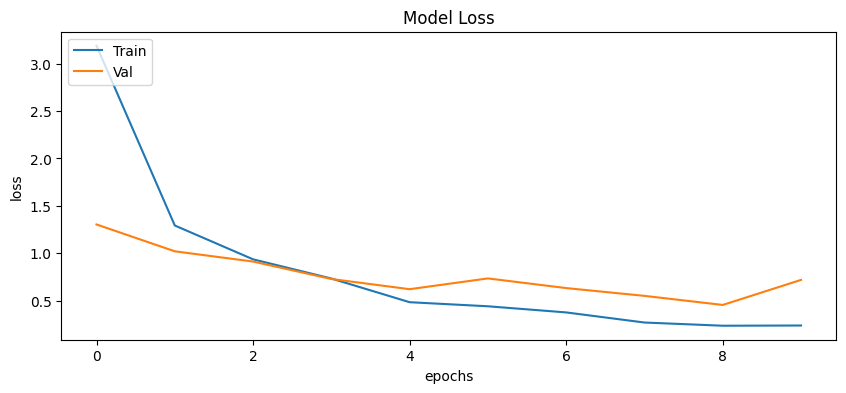

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()


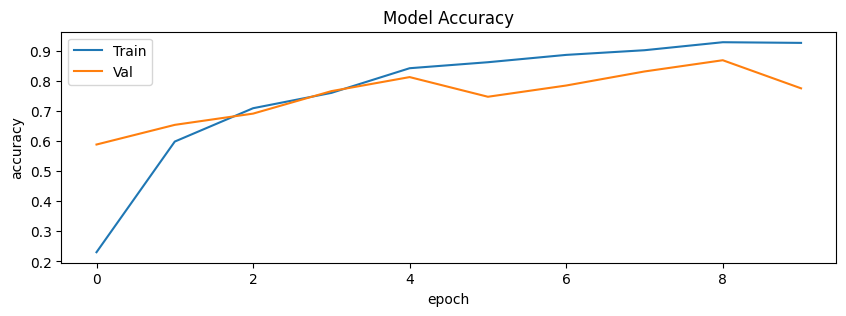

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Test dataset prediction accuracy:

In [ ]:

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 123,
    image_size=(img_height,img_width),
    shuffle=False
)

Found 98 files belonging to 19 classes.


In [ ]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
img_path = '/content/test_dir/CS120.07.442/IMG_20230920_144139.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print(class_names[np.argmax(preds)])
#print('Predicted:', decode_predictions( preds, top=19)[0])

1/1 [==============================] - 2s 2s/step
CS150.01.427-01


In [ ]:
test_images, test_labels = tuple(zip(*test_dataset))

predictions = model.predict(test_dataset)
score = tf.nn.softmax(predictions)

4/4 [==============================] - 9s 2s/step


In [ ]:
result = model.evaluate(test_dataset)
print("Test loss, test accuracy:", result)

4/4 [==============================] - 8s 2s/step - loss: 0.6105 - accuracy: 0.8163
Test loss, test accuracy: [0.6104856729507446, 0.8163265585899353]


### Thus, the accuracy is 94.2%

## Classification report:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_test = np.concatenate(test_labels)
y_pred = np.array([np.argmax(s) for s in score])

print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

     CS120.01.413       1.00      1.00      1.00         6
     CS120.07.442       0.67      1.00      0.80         6
  CS150.01.427-01       1.00      0.60      0.75         5
     SU160.00.404       0.83      1.00      0.91         5
      SU80.01.426       1.00      0.75      0.86         4
     SU80.10.409A       1.00      1.00      1.00         5
    ЗВТ86.103К-02       1.00      0.60      0.75         5
       СВМ.37.060       1.00      0.75      0.86         4
      СВМ.37.060А       1.00      1.00      1.00         6
   СВП-120.00.060       1.00      1.00      1.00         4
    СВП120.42.020       0.67      0.80      0.73         5
    СВП120.42.030       0.80      0.80      0.80         5
СК20.01.01.01.406       1.00      0.40      0.57         5
СК20.01.01.02.402       1.00      0.20      0.33         5
СК30.01.01.02.402       0.44      1.00      0.62         4
СК30.01.01.03.403       1.00      0.60      0.75       

In [ ]:
# Укажите путь для сохранения модели
model_save_path = '/content/model.h5'

# Сохраните модель
model.save(model_save_path)
print("Model saved to", model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Укажите путь к файлу модели
model_path = '/content/model.h5'

# Загрузите модель
loaded_model = load_model(model_path)


In [ ]:
!pip install opencv-python-headless


In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

# Функция для загрузки и предобработки изображения перед классификацией
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цветового пространства
    image = image.astype(np.float32)  # Преобразование к float32
    image = image / 255.0  # Нормализация пикселей
    image = np.expand_dims(image, axis=0)  # Добавление размерности батча
    return image

# Функция для обновления изображения
def update_image(_):
    ret, frame = cap.read()  # Считываем кадр с веб-камеры

    if not ret:
        return

    # Предобрабатываем кадр перед классификацией
    input_image = preprocess_image(frame)

    # Классификация изображения с помощью модели
    predictions = loaded_model.predict(input_image)
    predicted_class = class_names[np.argmax(predictions)]

    # Добавляем подпись к видеопотоку
    cv2.putText(frame, predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Обновляем изображение в виджете
    image_widget.value = bytes(cv2.imencode('.jpg', frame)[1])


# Функция для остановки захвата и освобождения ресурсов
def stop_capture(_):
    image_timer.close()
    cap.release()
    clear_output()

# Создаем виджет для отображения изображения
image_widget = widgets.Image(format='jpeg')

# Открываем веб-камеру
cap = cv2.VideoCapture(0)  # 0 - индекс веб-камеры

# Создаем кнопку для остановки захвата
stop_button = widgets.Button(description="Stop Capture")

# Привязываем функцию обновления изображения к нажатию кнопки
stop_button.on_click(stop_capture)

# Создаем таймер для обновления изображения
update_interval = 100  # В миллисекундах
image_timer = widgets.interactive(update_image)
widgets.jslink((image_timer, 'value'), (image_timer.children[0], 'value'))

# Отображаем виджет с изображением и кнопку
display(widgets.HBox([image_widget, stop_button]))



ValueError: ignored